## Fit a CNN model to a sample of the data

In [1]:
import sys
sys.path.append('..')

In [2]:
import os

import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

In [3]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
# sample 1000 protein-ligand complexes from the dataset

path_to_dataset = "../data/pdbbind2020-refined-prepared/"  # suppose you have downloaded the dataset
dataframe = pd.read_csv(os.path.join(path_to_dataset, "index.csv"))

samples = dataframe[dataframe.lppdbbind_split == "train"].sample(1000)
samples.head()

,id,resolution,release_year,pki,ki,delta_g,lig_name,coreset_v2013,coreset_v2016,lppdbbind_split
2210,4d4d,1.40,2015,5.96,1.100,-8.124923,MAN-IFM,False,False,train
1448,6qr1,1.67,2019,5.07,8.500,-6.914045,JFT,False,False,train
223,5ehv,1.21,2016,3.08,826.000,-4.203885,5ON,False,False,train
2931,6dar,1.88,2018,6.66,0.219,-9.080708,G2J,False,False,train
72,4y4j,1.03,2016,2.47,3400.000,-3.365978,LNR,False,False,train


In [5]:
# load voxels 
path = os.path.join(path_to_dataset, "{0}/voxels/{0}.npy")
data = np.array([np.load(path.format(id_)) for id_ in samples.id.values])

data.shape

(1000, 21, 24, 24, 24)

In [13]:
# we could also select a subset of channels to use
# e.g., channels 9-14 represent protein atoms only (CHONS) and
# channels 15-20 represent ligand atoms only (CHONS)


# path = os.path.join(path_to_dataset, "{0}/voxels/{0}.npy")
# data = np.array([np.load(path.format(id_))[np.r_[9:14, 15:20]] for id_ in samples.id.values])

# data.shape
# (1000, 10, 24, 24, 24)

In [7]:
class VoxelDataset(Dataset):
    def __init__(self, dataset, labels) -> None:
        self.dataset = torch.tensor(dataset)
        self.labels = torch.tensor(labels)
    
    def __len__(self) -> int:
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx]

dataset = VoxelDataset(data, samples.delta_g.to_numpy(dtype=np.float32))
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [8]:
# define the model and other training hyperparameters

class CNN(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        in_channels = 21

        self.conv1 = torch.nn.Conv3d(in_channels, 64, 5, padding=2, stride=2)
        self.conv2 = torch.nn.Conv3d(64, 128, 5, padding=2, stride=2)
        self.conv3 = torch.nn.Conv3d(128, 256, 5, padding=2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(256 * 3 * 3 * 3, 512)
        self.linear2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 1)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.relu(self.conv3(x))
        x = self.flatten(x)
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
        x = self.out(x)
        
        return x
    
model = CNN()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
# train the model

def train(dataloader, model, loss_fn, optimizer, max_epochs=50):
    model.train()
    model.to("cuda")

    logs = {"steps": [], "loss": []}
    step_count = 0
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        for _, batch in pbar:
            x, y = batch                    

            # forward pass
            preds = model(x.cuda())
            loss = loss_fn(preds.squeeze(), y.to("cuda"))

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log
            logs["steps"].append(step_count := step_count + 1)
            logs["loss"].append(loss.item())
            pbar.set_description(f"epoch: {epoch} loss: {loss.item():>3.3f}")
            
    return logs

logs = train(dataloader, model, loss_fn, optimizer)

epoch: 49 loss: 0.173: 100%|██████████| 20/20 [00:00<00:00, 22.88it/s]


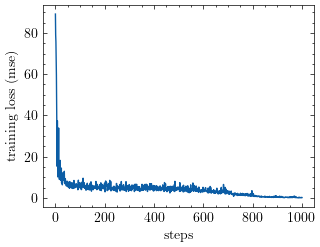

In [10]:
import matplotlib.pyplot as plt
import scienceplots

with plt.style.context(["science"]):
    plt.figure()
    plt.plot(logs["steps"], logs["loss"])
    plt.xlabel('steps')
    plt.ylabel('training loss (mse)')
    # plt.savefig("train.svg", dpi=300)
    plt.show()

In [11]:
# save logs to a dataframe

logs_df = pd.DataFrame(logs)
# logs_df.to_csv("train.csv", index=False)